# Data Fitting and Least Action Principle

## Introduction

As discsussed in the note, data fitting and the least action principle are equivalent. In this notebook, we explore this equivalence by considering the dynamics of oscillators. We are to reveal the true action from the raw data.

## Configurations

To challange our theory, we consider an oscillator a little more complex than the harmonic oscillator. The dynamcs is

$$ \ddot{x} = -g_1 x - \frac{g_3}{3!} x^3 - \frac{g_5}{5!} x^5 - \cdots. $$

On the right hand side, only odd terms involved. This is for ensuring the parity symmetry. The couplings $(g_1, g_3, \ldots)$ shall be finite of course. In this experiment, we give the target couplings, the `TARGET_COUPLINGS`. And with these couplings, simulation data are generated by numerically solving the differential equation of the dynamics. The simulation starts at time `0` and ends at the `MAX_TIME`. By randomly initializing position and velocity, `DATA_SIZE` simulation data are generated. In the real world situation, measurement errors are inevitable. We also consider adding a Gaussian error with std `MEASUREMENT_ERROR_STD` to the simulaiton data.

In [2]:
TARGET_COUPLINGS = [2., 10.]
NUM_FRAMES = 501
MAX_TIME = 10.
DATA_SIZE = 10**4
BATCH_SIZE = 128
# MEASUREMENT_ERROR_STD = 3e-2
MEASUREMENT_ERROR_STD = 0.

In [1]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras

## Data Generation

In [3]:
def oscillator_ode(y, t):
    x, v = y
    dx = v
    dv = -sum(g / math.factorial(2*i+1) * x**(2*i+1)
              for i, g in enumerate(TARGET_COUPLINGS))
    return [dx, dv]

In [4]:
%%time
t_span = np.linspace(0, MAX_TIME, NUM_FRAMES)
raw_data = np.zeros([DATA_SIZE, NUM_FRAMES, 2])  # initialize.
for i in range(DATA_SIZE):
    # Randomly initialize the position and the velocity
    x_init = np.random.uniform(low=-1, high=1)
    v_init = np.random.uniform(low=-1, high=1)

    sol = odeint(oscillator_ode, [x_init, v_init], t_span)
    raw_data[i, :, :] =  sol

# Add measurement errors
measure_err = np.random.normal(scale=MEASUREMENT_ERROR_STD, size=raw_data.shape)
data = raw_data + measure_err

CPU times: user 20.8 s, sys: 248 ms, total: 21 s
Wall time: 28.4 s


Let us show an instance.

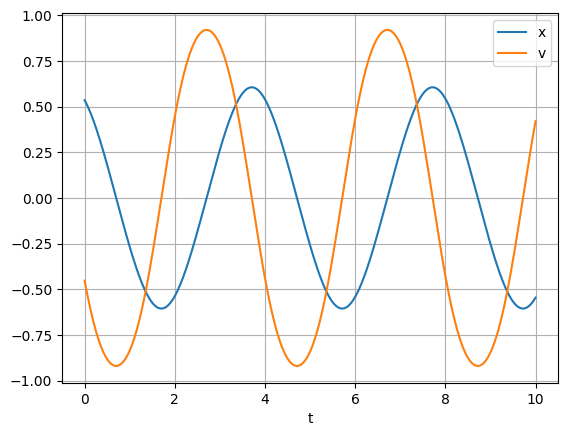

In [5]:
plt.plot(t_span, data[0, :, 0], label='x')
plt.plot(t_span, data[0, :, 1], label='v')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

Convert to `tf.data.Dataset` protocol.

In [6]:
ds = tf.data.Dataset.from_tensor_slices(data[:, :, 0].astype('float32'))

## Model

The action is constructed as

$$ S(x; g) = \frac{1}{2} \dot{x}^2 - \frac{g_2}{2!} x^2 - \frac{g_4}{4!} x^4 - \cdots, $$

where the collection $g$ which has finite elements are to be trained to fit the data. The $\dot{x}$ is computed by difference.

In [7]:
class Action(keras.Model):

    def __init__(self, couplings):
        super().__init__()
        self.couplings = couplings

    def call(self, xs, ts):
        # Kinetic term:
        dx = xs[:, 1:] - xs[:, :-1]
        dt = ts[:, 1:] - ts[:, :-1]
        action_value = 0.5 * tf.reduce_mean(tf.square(dx / dt), axis=1)
        # Potential term
        for i, g in enumerate(self.couplings):
            action_value -= (
                g / math.factorial(2*i+2) *
                tf.reduce_mean(tf.pow(xs, 2*i+2), axis=1)
            )
        return action_value

model = Action([tf.Variable(0.), tf.Variable(0.)])

In [8]:
xs = tf.convert_to_tensor(data[:BATCH_SIZE, :, 0], dtype=tf.float32)  # test data.
ts = tf.convert_to_tensor(t_span[np.newaxis, :], dtype=tf.float32)

In [9]:
model(xs, ts)  # build the model.

To sample from the distribution $p(\cdot, \theta)$ in the note, where $\theta$ is the $g$ herein, we employ Langevin dynamics, which is also discussed in the note.

In [11]:
def gradient(fn, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = tf.reduce_sum(fn(x))
    return tape.gradient(y, x, unconnected_gradients='zero')

gradient(lambda xs: model(xs, ts), xs)

<tf.Tensor: shape=(128, 501), dtype=float32, numpy=
array([[ 0.04662663,  0.00258833,  0.00252217, ..., -0.00283977,
        -0.00277921,  0.04064583],
       [-0.0670397 , -0.00033274, -0.00027792, ...,  0.00164019,
         0.00158606, -0.04481647],
       [ 0.03940344,  0.00154927,  0.00150636, ..., -0.00200497,
        -0.00202025, -0.00937821],
       ...,
       [ 0.0109309 , -0.00263065, -0.00264257, ...,  0.0021011 ,
         0.00216297,  0.04180404],
       [ 0.09637446, -0.00073604, -0.00081927, ...,  0.00091914,
         0.00102194,  0.09261848],
       [ 0.05351305,  0.00697405,  0.00681281, ...,  0.00526528,
         0.00552147,  0.10019322]], dtype=float32)>

In [12]:
@tf.function
def langevin_sampling(fn, init, dt, T, num_steps):
    std = tf.sqrt(2. * T * dt)
    x = init
    for _ in tf.range(num_steps):
        dW = tf.random.truncated_normal(tf.shape(x), 0., std)
        x += -gradient(fn, x) * dt + dW
    return x

sampled = langevin_sampling(lambda xs: model(xs, ts), xs, 1e-1, 1e-8, 100)
sampled

<tf.Tensor: shape=(128, 501), dtype=float32, numpy=
array([[ 0.44603133,  0.44482732,  0.44263408, ..., -0.58201844,
        -0.5819445 , -0.5818018 ],
       [ 0.00517133,  0.00622643,  0.00825016, ...,  0.40348113,
         0.40262455,  0.40227324],
       [ 0.28867668,  0.2878324 ,  0.28624573, ..., -0.4059619 ,
        -0.40693855, -0.4074099 ],
       ...,
       [-0.5239836 , -0.52371335, -0.52307653, ...,  0.3859082 ,
         0.3879568 ,  0.38877958],
       [-0.2948181 , -0.29606405, -0.2985452 , ...,  0.11135826,
         0.11439444,  0.11582568],
       [ 0.85323894,  0.85129327,  0.84760475, ...,  0.6808269 ,
         0.6855956 ,  0.687831  ]], dtype=float32)>

Let us compare the difference between the sampled data and the target data. By comparing these two figures carefully, we will find the differences that cannot be omitted.

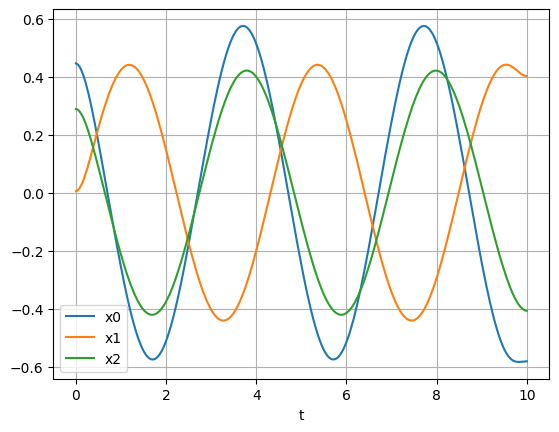

In [13]:
def plot_samples(samples, ts=t_span):
        for i in range(samples.shape[0]):
            plt.plot(ts, samples[i, :], label=f'x{i}')
        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

plot_samples(sampled[:3, :])

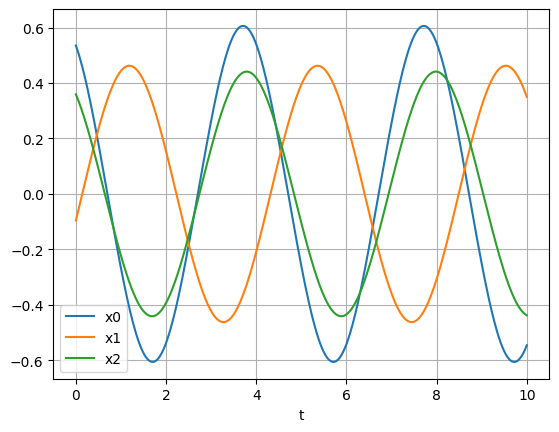

In [14]:
plot_samples(xs[:3, :])

The loss is the $L_{\text{LA}}$ is the note. That is, the loss that induces the least action principle. Conventionally, we call the sampled data as "fantacy data", as if they are dreamed by the model.

We have to twist the hyper-parameters in the `langevin_sampling` so that the loss value are proper for training (for example, it should not be `NaN`). And it is positive in most trials, otherwise bug shall exist.

In [15]:
@tf.function
def get_loss(xs, ts):
    fantacy = langevin_sampling(lambda x: model(x, ts), xs, 1e-1, 1e-8, 10)
    return tf.reduce_mean(model(xs, ts)) - tf.reduce_mean(model(fantacy, ts))

get_loss(xs, ts)

<tf.Tensor: shape=(), dtype=float32, numpy=0.007553786>

In [16]:
def get_train_step(model, optimizer):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)

    @tf.function
    def train_step_fn(batch):
        with tf.GradientTape() as tape:
            loss_value = get_loss(batch, ts)
        grads = tape.gradient(loss_value, model.couplings)
        optimizer.apply_gradients(zip(grads, model.couplings))
        step.assign_add(1)
        return loss_value

    return train_step_fn, step

optimizer = keras.optimizers.adam_v2.Adam()
train_step, step = get_train_step(model, optimizer)

In [17]:
train_ds = ds.shuffle(1000).repeat(200).batch(BATCH_SIZE)
process_bar = keras.utils.generic_utils.Progbar(len(train_ds))
for batch in train_ds:
    loss_value = train_step(batch)
    process_bar.update(current=tf.cast(step, tf.float32),
                       values=[('loss', loss_value)])

15625/15625 [==============================] - 268s 17ms/step - loss: 0.0036


It can be found that the trained couplings are almost the same as the target, at least when the measurement errors are small enough.

In [18]:
model.couplings

ListWrapper([<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.032266>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=9.388299>])

Let compare the sampled data from the trained model/action with the real/simulation data. We will find that they match perfectly.

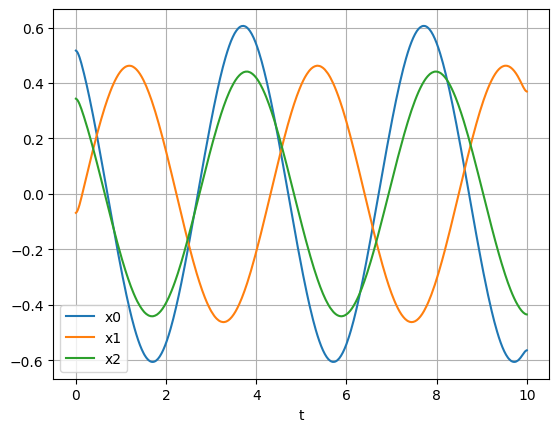

In [19]:
sampled = langevin_sampling(lambda xs: model(xs, ts), xs, 1e-1, 1e-8, 10)
plot_samples(sampled[:3, :])

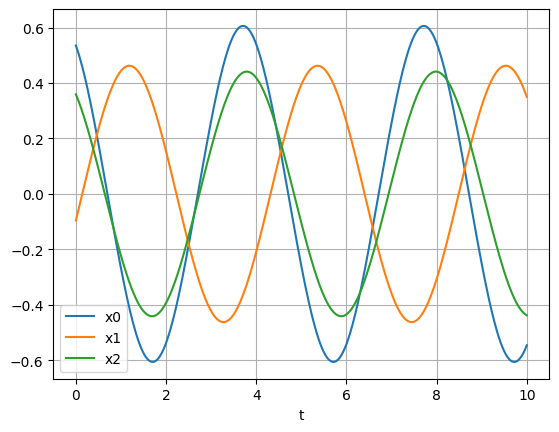

In [20]:
plot_samples(xs[:3, :])

## Conclusion

We find that, by data fitting, the least action principle is revealed perfectly.

When the measurement errors are not small enough, the higher order couplings of the trained will not match the target. This is not a problem. If you compare the plots between the sampled data and the simulation data, the result is still perfect. The result is insensitive to the higher order couplings. For this reason, the higher order couplings do not match the target.